# Linear Regression

In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

## Basics

Regression is whenever we want to predict a value based on some number of features. In the following example, assume we wish to predict the value (in dollars) of houses based on their size (in sq. feet) and age (in years). First we have to get our hands on some training data. Each row of this training set is an example. The house prices in this training set are the labels/targets. The age and price are the features/covariates. 

Linear regression is one of the simplest amnd most popular standard tools. Assume the relationsip between the features $\mathbf{x}$ and $y$ is approximately linear, but allow for some random noise, which we assume to be Gaussian. 

Use $n$ to represent the number of _examples_ in our training dataset. Use superscripts to enumerate samples and targets, and subscripts to index coordinates. $\mathbf{x}^{(i)}$ indicates the vector of features for the $i$th sample/example. $x^{(i)}_j$ indicates its $j$th coordinate/feature. 

### Model

The assumption of linearity means that the expectation value of the target may be expressed in terms of a weighted sum of the features, that is:

$$ \hat{y}^{(i)} = w^{(i)}_{age}x^{(i)}_{age} + w^{(i)}_{sqft}x^{(i)}_{sqft} + b$$

Where w are the weights and b is the bias, or offset, representing the intercept of the linear model with the y axis. Although there is no "real" house with a square footage of 0, this value is still relevant for ensuring that the model is fit correctly. Presumably our assumption of linearity would break down outside of the limits of a normal/acceptable house size.

Our task, given a particular dataset, is to find a set of weight $\mathbf{w}$ such that the difference between our predicted value $\hat{y}$ and and the true/observed values $y$ is minimised.

In ML, typically use compact notation: When our inputs consist of $d$ features, typically assign each an index between 1 and d, rather than names and express our prediction as $\hat{y}$. So the equation above would become

$$ \hat{y} = w_1x_1 + w_2x_2 + ... + w_dx_d +b $$

By collecting all the features into a vector $\mathbf{x} \in \mathbb{R}^d$ and all the weights into a vector $\mathbf{w} \in \mathbb{R}^d$, we can express this more compactly

$$ \hat{y} = \mathbf{w}^{\intercal}\mathbf{x} + b$$  

Where $\mathbf{x}$ refers to the features of a single example. In general it is more convenient/sensible to express this model in terms of the $\mathbf{X} \in \mathbb{R}^{n \times d}$ matrix of features, where each row n is an example, with d features. 

In this case, the vector of predictions $\mathbf{\hat{y}} \in \mathbb{R}^{n}$ for all our examples can be expressed as a matrix-vector product

$$ \mathbf{\hat{y}} = \mathbf{X}\mathbf{w} + b$$

Where broadcasting is applied during the summation. 

The goal of machine learning, given some observed features $\mathbf{X}$ with associated labels $\mathbf{y}$, is to find the set of weights $\mathbf{w}$ and bias $b$ such that the predicted labels $\mathbf{\hat{y}}$ given some new dataset are as close as possible to the real labels as possible, or, in other words, that the error of the predicted values is minimised.

Even in an idealised case where the underlying relation truly is linear, we still would not expect our prediction for every example to be 0, due to experimental error and other sources of error inherent in real world data. Therefore, it is important to incorporate a noise term to account for this.

Before we can go about trying to find the best _paramaters_ $\mathbf{w}$ and $b$, we need two things
1. A way to measure the performance of the model.
2. Some way for updating the parameters to improve the model accuracy.

### Loss function

Naturally, fitting the model requires an agreed-upon definition of the fitness (or unfitness) of the model. This is computed through evaluating a _loss function_. Typically, loss functions are positive values, where a smaller value indicates better performance, and a perfect predictor incurrs a loss of 0. For regression problems, the squared error is the most common loss function. For a prediction on the $i$th example, $\mathbf{\hat{y}}^{(i)}$, with the corresponding true label $\mathbf{y}^{(i)}$, the squared error is given by:

$$ l^{(i)}(\mathbf{w}, b) = \frac{1}{2}(\mathbf{y}^{(i)} - \mathbf{\hat{y}}^{(i)})^2$$

Where the constant of $\frac{1}{2}$ has no particular meaning, but is convenient as it cancels out with the power of 2 when taking the derivative of the loss. 

Because the composition and quality of the training dataset is (to a first approximation) out of our control, the loss is a function exclusively of the weights and biases of our model.

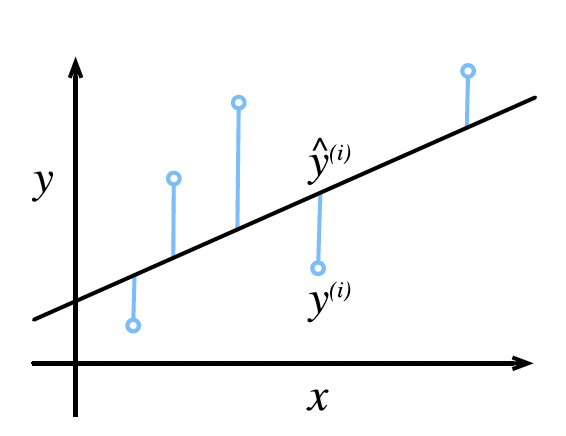

In the above figure, the error of a linear model with respect to the real data is shown. Large differences between $\hat{y}^{(i)}$ and $\hat{y}^{(i)}$ can lead to large values for the loss function due to the squared nature of the error. This is a bit of a double-edged sword, while it does effectively penalise large errors, it can also result in excessive sensitivity to anomalous data.

To measure the quality of the model on an entire dataset of $n$ training data points, we simply average (or equivalently, sum) the values for the loss over each data point.

$$ L(\mathbf{w}, b) = \frac{1}{n} \sum_{i=1}^n l^{(i)}(\mathbf{w}, b) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2}(\mathbf{\hat{y}} - \mathbf{y})^{2} = \frac{1}{n} \sum_{i=1}^n \frac{1}{2}(\mathbf{w}^{\intercal}\mathbf{x}^{(i)} + b - \mathbf{y})^2 = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}(\mathbf{Xw} + b - \mathbf{y})^2 $$

When training a model, we seek parameters $(\mathbf{w}^*, b^*)$ to minimise the loss over all training samples

$$ \mathbf{w}^*, b = \mathrm{argmin}_{\mathbf{w}, b}(L(\mathbf{w, b}))$$

### Analytic Solution

Unlike most ML modelling methods, linear regression actually has an analytical solution.

First, we subsume the bias $b$ into the design matrix $\mathbf{X}$ by appending a column of all 1's (corresponding roughly to an additional feature, the value for which is 1 across all samples). Then, our prediction problem is to minimise $||\mathbf{y} - \mathbf{Xw}||^2$. Assuming that the design matrix $\mathbf{X}$ is [full rank](https://en.wikipedia.org/wiki/Rank_(linear_algebra)), meaning that no feature is linearly dependant on the others, the loss function will have one critical point, which will correspond to its minium. 

Taking the derivative of the loss function with respect to $\mathbf{w}$ and setting it equal to zero gives

$$\partial_{w}||\mathbf{y} - \mathbf{Xw}||^2 = 2\mathbf{X}^{\intercal}(\mathbf{X}\mathbf{w} - \mathbf{y}) = 0$$

hence,

$$\mathbf{X}^{\intercal}\mathbf{y} = \mathbf{X}^{\intercal}\mathbf{X}\mathbf{w}$$

solving for $\mathbf{w}$ gives.

$$\mathbf{w}^* = (\mathbf{X}^{\intercal}\mathbf{X})^{-1}\mathbf{X}^{\intercal}\mathbf{y}$$

Note that the solution to this will only be unique when the matrix $\mathbf{X}{X}^{\intercal}$ is invertible, that is, the columns of the design matrix are linearly independent. 

### Minibatch Stochastic Gradient Descent

In order to compute $\mathbf{w}$ for all the other non-linear, more interesting problems, we need a numerical method for evaluating the gradients and optimising the weights based on these. The most naively appealing method for doing this is the algorithm known as _gradient descent_, which computes the derivative of the loss with respect to $\mathbf{w}$ across the whole dataset. This is problematic and slow for large datasets and quickly becomes unwieldy; we must pass over the entire dataset before updating the weights.

Stochastic gradient descent attempts to solve this by computing the derivatives on one sample at a time. A major drawback of this is that processors are much more efficient at multiplying two numbers than they are moving numbers from RAM to CPU cache. Performing a Matrix-Vector multiplicatio can be an order of magnitude faster than performing the equivalent vecotr-vector operations individually. 

A middle ground is minibatch stochastic gradient descent. Where the data is split into small batches (some large power of 2, i.e. 32-256 samples).

